In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from sklearn.linear_model import LogisticRegression
from toolz.functoolz import pipe

import numpy as np

In [2]:
from matplotlib.font_manager import fontManager, FontProperties

path = "helvetica.ttf"
fontManager.addfont(path)

prop = FontProperties(fname=path)
sns.set(font=prop.get_name())

from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib
plt.rcParams['font.size']=20.
plt.rcParams['axes.labelsize']=20.
plt.rcParams['axes.titlesize']=22.
plt.rcParams['legend.fontsize']=18.
plt.rcParams['savefig.dpi']=1000
plt.rcParams['xtick.labelsize']=17.
plt.rcParams['ytick.labelsize']=17.
plt.rcParams['xtick.minor.size']=3
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.minor.size']=3
plt.rcParams['ytick.major.size']=5
plt.rcParams['xtick.major.width']=1.
plt.rcParams['xtick.minor.width']=1.
plt.rcParams['ytick.major.width']=1.
plt.rcParams['ytick.minor.width']=1.
plt.rcParams['axes.linewidth']=2.
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.constrained_layout.use'] = True

# Process Model output

In [3]:

["index"] + [f"match{2**i}" for i in range(0, 9)]
all_dfs = []

for i in range(10000, 43001, 3000):
    df = pl.scan_csv(f"../results/memorization-dyn-count/evals-running/memorization_410m-deduped_{i}_10240000_lev/*.csv", has_header=False, new_columns = ["index", "longest_match", "overlap", "lev"])
    # df["index"] = df["index"].cast(pl.Int64)
    df = df.with_columns(checkpoint = pl.lit(i))
    all_dfs.append(df)
all_dfs = pl.concat(all_dfs)

In [4]:
df1 = all_dfs.collect().to_pandas()

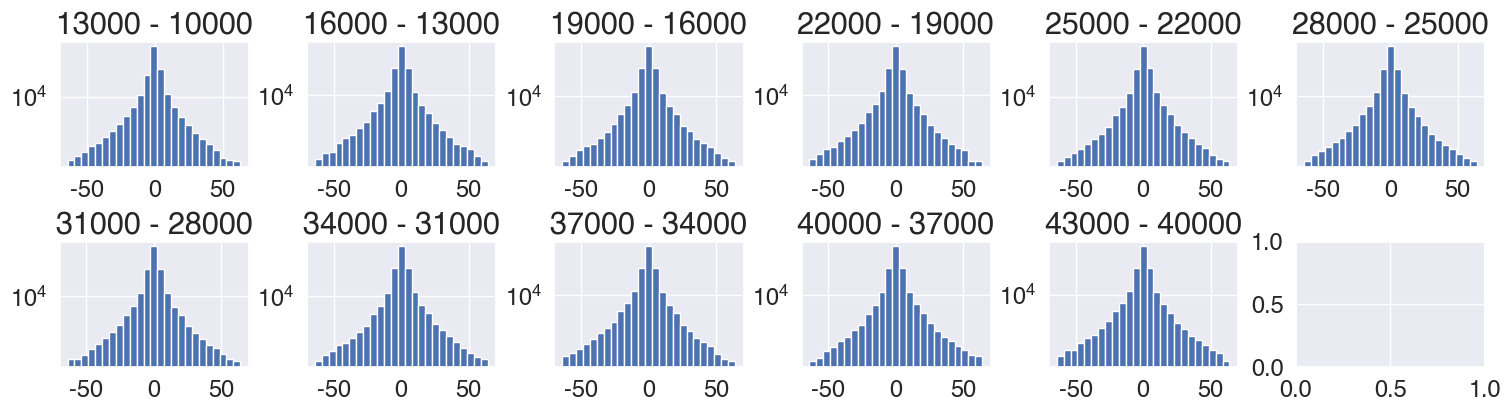

In [5]:
d = all_dfs.collect().pivot("lev", "index", "checkpoint", aggregate_function="mean")

f, ax = plt.subplots(2, 6, figsize=(15, 4))
for i in np.arange(0, 11):
    ax[i//6, i%6].hist(d[str(i*3000+13000)] - d[str(i*3000 + 10000)], bins=25)
    ax[i//6, i%6].set(yscale='log')
    ax[i//6, i%6].set(title=f'{i*3000 + 13000} - {i*3000 + 10000}')
    # ax[(i-1)//6, (i-1)% 6].set_title(f'{i*1000 + 1000} - {i*1000}')
# ax[0, 0].set_ylabel('counts')
# ax[1, 0].set_ylabel('counts')
# ax[2, 0].set_ylabel('counts')
# f.savefig('../figures/weight_change.pdf')

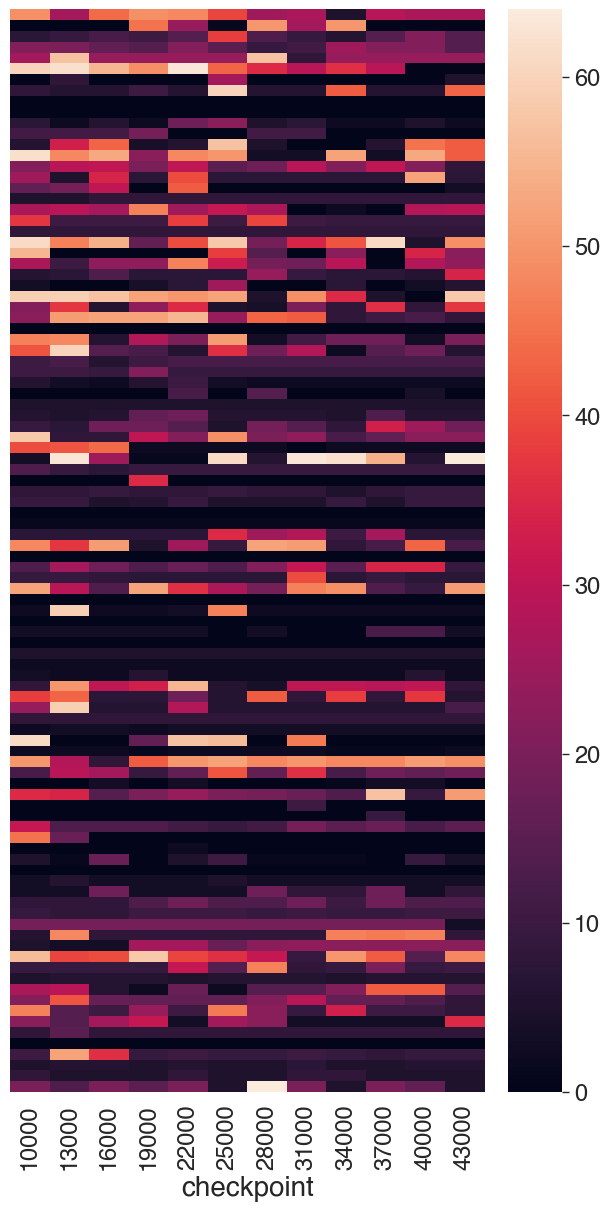

In [6]:
f, ax = plt.subplots(figsize=(6, 12))

df_t = d.to_pandas()
df_t = df_t[(df_t.iloc[:, 1:].min(axis=1)) < 10]
sns.heatmap(df_t.iloc[:100, 1:], ax=ax)
ax.set(yticks=[], xlabel='checkpoint')
f.savefig('../figures/dynamics.pdf')


# Complexity

In [7]:
df = all_dfs.collect().to_pandas().set_index(["index", "checkpoint"]).sort_values(by=["index", "checkpoint"])
df = df[~df.index.duplicated(keep='first')]
df["diff"] = df["lev"].shift(-1) - df["lev"]
df

longest_match  overlap  lev  diff
index    checkpoint                                   
10240000 10000                   0        1   62   2.0
         13000                   0        0   64  -4.0
         16000                   0        1   60   1.0
         19000                   0        3   61   3.0
         22000                   0        0   64  -1.0
...                            ...      ...  ...   ...
11264511 31000                   0        3   61  -2.0
         34000                   3        5   59   2.0
         37000                   3        3   61   0.0
         40000                   3        3   61  -1.0
         43000                   3        4   60   NaN

[12294144 rows x 4 columns]

In [8]:
df = df[df.index.get_level_values(0) < 11000 * 1024]

/tmp/ipykernel_4025257/3635784038.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["complexity"] = comp


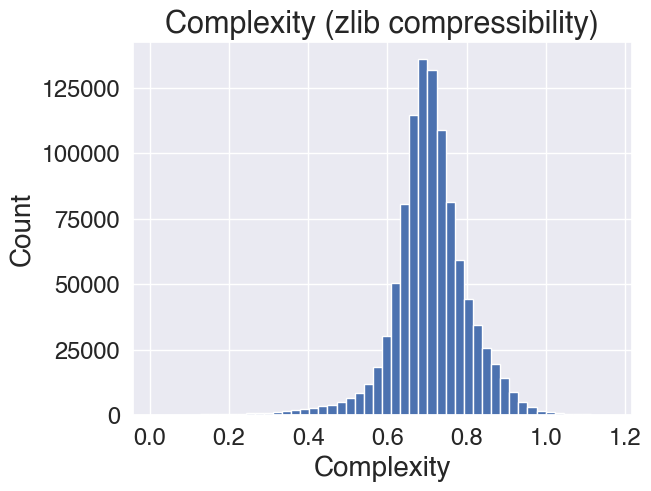

In [9]:
complexity = np.load('../results/deduped/zcomplexity.npy')
ser = pd.DataFrame(complexity)
ser.index = np.arange(len(complexity)) + 1024 * 10000
ser.columns = ["complexity"] #np.arange(1, 256)
comp = df.apply(lambda x: ser.loc[x.name[0], "complexity"], axis=1)
df["complexity"] = comp
# ser[0] = 1.0
f, ax = plt.subplots()
ax.hist(ser.loc[:, "complexity"], bins=50)
ax.set_title("Complexity (zlib compressibility)")
ax.set_ylabel("Count")
ax.set_xlabel("Complexity")
f.savefig("../figures/complexity.pdf")


In [10]:
df.to_parquet('../results/deduped/analysis.parquet.gzip',
              compression='gzip') 

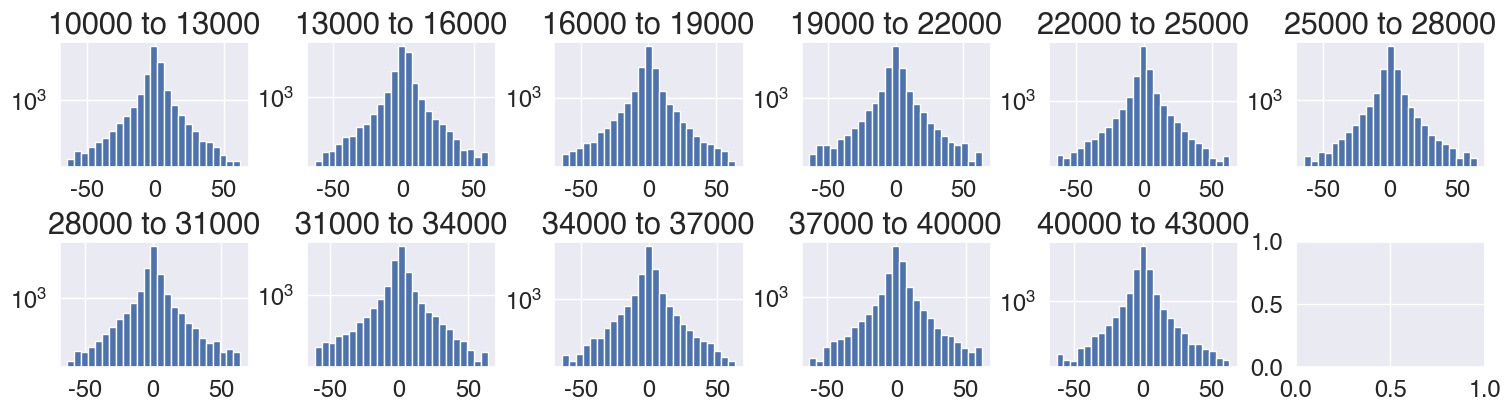

In [25]:
d = df.query('complexity > 0.8').reset_index().pivot(values="lev", index="index", columns="checkpoint")
f, ax = plt.subplots(2, 6, figsize=(15, 4))
for i in np.arange(0, 11):
    ax[i//6, i%6].hist(d[(i*3000+13000)] - d[(i*3000 + 10000)], bins=25)
    ax[i//6, i%6].set(yscale='log')
    ax[i//6, i%6].set(title=f'{i*3000 + 10000} to {i*3000 + 13000}')
np.save('../results/deduped/filtered_dyn', d.to_numpy())

# Visualize

In [21]:
df = pd.read_parquet('../results/deduped/analysis.parquet.gzip')

In [22]:

indices_0_1 = (pipe(df,
         lambda x: x[x.index.get_level_values(1) != 10000],
         lambda x: x.groupby(x.index.get_level_values(0)).min()["lev"] < 10) & 
       pipe(df,
            lambda x: x[x.index.get_level_values(1) == 10000],
            lambda x: (x["lev"] >= 40) & (x["complexity"] > 0.8),
            ) 
            # & pipe(df, lambda x: x.groupby(x.index.get_level_values(0)).min()["cumsum30"] == 1)
        )
np.save('../results/deduped/indices_complex_0_1.npy', np.array(indices_0_1[indices_0_1].index.get_level_values(0).unique()))

In [23]:
np.array(indices_0_1[indices_0_1].index.get_level_values(0).unique()).shape

(217,)

In [24]:
indices = np.array(df[df["complexity"] > 0.9].index.get_level_values(0).unique())
np.save('../results/deduped/indices_complex.npy', indices)

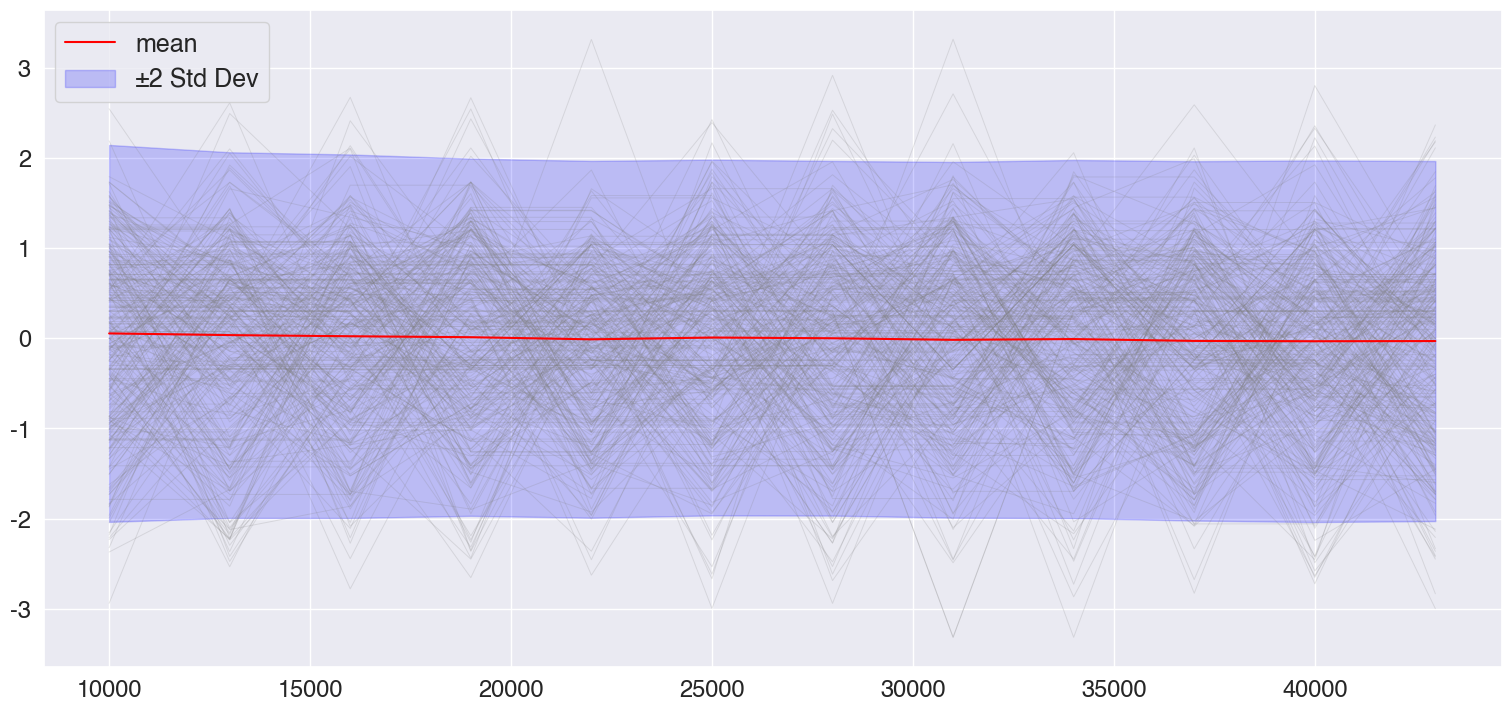

In [27]:
f, ax = plt.subplots(figsize=(15, 7))
d = df[df["complexity"] > 0.8]
d = d["lev"].groupby(d.index.get_level_values(0)).agg(list)
x = np.array(d.tolist())
x = x[np.std(x, axis=1) != 0]
x = (x - np.mean(x, axis=1)[:, None]) / np.std(x, axis=1)[:, None]

indices = np.random.choice(x.shape[0], 300)
t = np.arange(10000, 43001, 3000)
plt.plot(t, x[indices, :].T, color='grey', alpha=0.2, linewidth=0.7);
m = np.mean(x, 0)
s = np.std(x, 0)
plt.plot(t, m, c='red', label="mean")
plt.fill_between(t, 
                 m - s*2, 
                 m + s*2, 
                 color='blue', alpha=0.2, label='±2 Std Dev')
plt.legend()
plt.savefig("../figures/dynamics_results.pdf")

In [28]:
d

index
10240000    [62, 64, 60, 61, 64, 63, 62, 62, 63, 61, 64, 60]
10240001    [61, 63, 64, 63, 64, 63, 64, 62, 64, 63, 63, 63]
10240003    [17, 22, 24, 20, 19, 61, 21, 25, 25, 28, 22, 25]
10240015    [59, 62, 62, 58, 59, 62, 62, 60, 63, 58, 58, 63]
10240016    [59, 59, 58, 58, 61, 59, 58, 59, 58, 61, 60, 60]
                                  ...                       
11263975    [55, 55, 55, 55, 51, 56, 54, 51, 51, 50, 51, 50]
11263984    [62, 61, 61, 60, 61, 62, 61, 63, 61, 61, 61, 61]
11263987    [62, 62, 61, 64, 64, 63, 60, 62, 62, 64, 62, 63]
11263992    [64, 63, 62, 63, 63, 64, 63, 62, 63, 63, 63, 64]
11263998    [61, 62, 62, 63, 57, 63, 64, 64, 61, 64, 62, 63]
Name: lev, Length: 142720, dtype: object

In [ ]:
f, ax = plt.subplots()
ax.hist2d(df[df.index.get_level_values(1) == 10000]["lev"],
           df[df.index.get_level_values(1) == 13000]["lev"], bins=40, norm='log')
ax.set(xlabel='Checkpoint 10000', ylabel='Checkpoint 13000', title='Levenshtein distance from true continuation')
f.savefig('../figures/mem_comparison.pdf')

In [1]:
df

NameError: name 'df' is not defined